In [ ]:
#tutorial here: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

In [1]:
from keras.datasets import mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from IPython.display import display
from PIL import Image

Using TensorFlow backend.


Train: X=(60000, 28, 28)s, y=(60000,)s
Test: X=(10000, 28, 28)s, y=(10000,)s


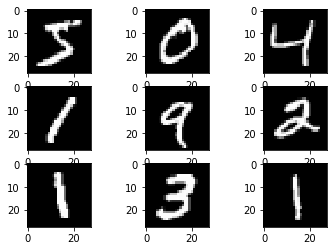

In [6]:
#loading the mnist dataset
(trainX, trainy), (testX, testy)=mnist.load_data()
#summarize mnist dataset i just loaded
print("Train: X={}s, y={}s".format(trainX.shape, trainy.shape))
print("Test: X={}s, y={}s".format(testX.shape, testy.shape))

#plot first few images
for i in range(9):
    #define subplot
    pyplot.subplot(330+1+i)
    #plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
#show the plot
pyplot.show()

### developing test harness with 5 key elements (1) loading dataset (2) prepping dataset (3) definiting model (4) evaluating model (5) presenting results

In [7]:
#load dataset
(trainX, trainY), (testX, testY)=mnist.load_data()

#reshape dataset to have a single colo channel
trainX=trainX.reshape((trainX.shape[0],28,28,1))
testX=testX.reshape((testX.shape[0],28,28,1))

In [8]:
#one hot encode target values
trainY=to_categorical(trainY)
testY=to_categorical(testY)

In [4]:
#function to load and one hot encode train and test dataset
def load_dataset():
    #load daaset
    (trainX, trainY), (testX,testY)=mnist.load_data()
    #reshape dataset to have single channel
    trainX=trainX.reshape((trainX.shape[0],28,28,1))
    testX=testX.reshape((testX.shape[0],28,28,1))
    #one hot encode target values
    trainY=to_categorical(trainY)
    testY=to_categorical(testY)
    return trainX, trainY, testX, testY

In [5]:
#preparing pixel data

#function to scale pixels: (1) convert from int to fload, (2) normalize pixel values to range 0-1
#need to call this fxn to prepare pixel values prior to modeling
def prep_pixels(train, test):
    #convert from int to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize to range 0-1
    train_norm=train_norm/255.0
    test_norm=test_norm/255.0
    #return nromalized images
    return train_norm, test_norm

In [11]:
#defining model

#function to define and return the model
def define_model():
    model=Sequential()
    #add a single convolutional layer with a small filer size (3,3) and modest number of filters (32)
    #NB: all layers will use ReLU activation function and He weight initialization scheme (best practices)
    model.add(Conv2D(32, (3,3), activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
    #add a max pooling layer
    model.add(MaxPooling2D((2,2)))
    #Feature extractor: flatten filter maps to provide features to classifier
    model.add(Flatten())
    #dense layer to interpret features (will use 100 nodes here)
    model.add(Dense(100, activation='relu',kernel_initializer='he_uniform'))
    #output layer: task will be to classify each of the 10 digits, so output layer will need 10 nodes to predict prob distribution of the 10 classes
    model.add(Dense(10, activation='softmax'))
    #stochastic gradient descent optimizer: here, learning rate=0.01, and momentum=0.9
    opt=SGD(lr=0.01, momentum=0.9)
    #compile model: categorical x-entropy loss function will be optimized and will monitor classification accuracy metric
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
#evaluating the model

#function to evaluate a model using k-fold cross-validation
#default to 5-fold x-validation
def evaluate_model(model, dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    #prepare cross validation
    kfold=KFold(n_folds, shuffle=True, random_state=1)
    #enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        #select rows for train and test
        trainX, trainY, testX, testY=dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        #fit model
        #will train using 10 trainig epochs and default batch size of 32
        history=model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        #evaluate model
        _, acc=model.evaluate(testX, testY, verbose=0)
        print('>%.3f' % (acc*100.0))
        #scores stores classification accuracy of each fold at the end of each run so we can estimate model performance
        scores.append(acc)
        #histories stores  training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable) so that we can plot the learning rate over each epoch
        histories.append(history)
    return scores, histories

In [13]:
#present results

#fxn to plot diagnostic learning curves: line plot showing model performance on train and test set during each k-fold validation to get a sense for over vs underfitting
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        #plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        #plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    

In [14]:
#function to summarize the classification accuracy scores collected during each fold
def summarize_performance(scores):
    #print summary
    print('AccuracY: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    #box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    

In [18]:
#functon that will run the test harness for evaluating a model
#remember we are leacing a hold-out test set that is not being included performance measures here!
def run_test_harness():
    #load and one hot encode dataset
    trainX, trainY, testX, testY = load_dataset()
    #prepare pixel data
    trainX, testX=prep_pixels(trainX, testX)
    #define model
    model=define_model()
    #evaluate model
    scores, histories = evaluate_model(model, trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    #summarize estimated performance
    summarize_performance(scores)
    return scores, histories
    

>98.458
>99.833
>99.992
>100.000
>100.000


c:\users\dbitterman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
c:\users\dbitterman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


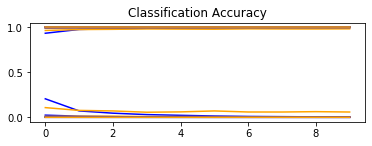

AccuracY: mean=99.657 std=0.603, n=5


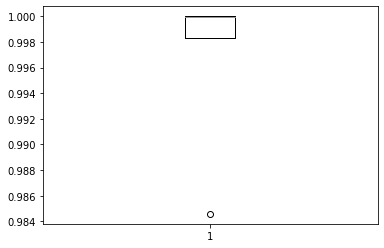

In [51]:
#entry point, run test harness
run_test_harness()

### Now will try to imrove the model

#### Batch normalization: Changes the distribution of the output layer by standardizing outputs --> stabilizing and accelerating learning process

In [19]:
# define new cnn model with batch normalization (also adding lr as parameter so easier to change later...)
def define_model_adapted(learning):
    model=Sequential()
    #add a single convolutional layer with a small filer size (3,3) and modest number of filters (32)
    #NB: all layers will use ReLU activation function and He weight initialization scheme (best practices)
    model.add(Conv2D(32, (3,3), activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
    #add Batch normalization after convolutional layer
    model.add(BatchNormalization())
    #add a max pooling layer
    model.add(MaxPooling2D((2,2)))
    #Feature extractor: flatten filter maps to provide features to classifier
    model.add(Flatten())
    #dense layer to interpret features (will use 100 nodes here)
    model.add(Dense(100, activation='relu',kernel_initializer='he_uniform'))
    #add batch normalization after fully connected layer
    model.add(BatchNormalization())
    #output layer: task will be to classify each of the 10 digits, so output layer will need 10 nodes to predict prob distribution of the 10 classes
    model.add(Dense(10, activation='softmax'))
    #stochastic gradient descent optimizer: here, learning rate=0.01, and momentum=0.9
    opt=SGD(lr=learning, momentum=0.9)
    #compile model: categorical x-entropy loss function will be optimized and will monitor classification accuracy metric
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
#adjusted test harness, now using the cnn model with batch normalization and with learning rate as an input parameter for flexibility later on...

def run_test_harness_adapted(learning):
    #load and one hot encode dataset
    trainX, trainY, testX, testY = load_dataset()
    #prepare pixel data
    trainX, testX=prep_pixels(trainX, testX)
    #define model
    model=define_model_adapted(learning)
    #evaluate model
    scores, histories = evaluate_model(model, trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    #summarize estimated performance
    summarize_performance(scores)
    return scores, histories

>98.675
>99.908
>100.000
>99.992
>100.000


c:\users\dbitterman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
c:\users\dbitterman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


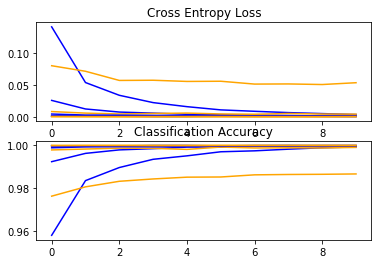

AccuracY: mean=99.715 std=0.521, n=5


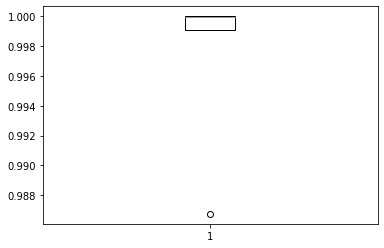

In [62]:
#entry point, run adapted test harness
scores1, histories1 = run_test_harness_adapted(learning=0.01)

#### Will try to improve model by increasing model depth

In [9]:
def define_model_adapted_deeper(learning):
    model=Sequential()
    #add a single convolutional layer with a small filer size (3,3) and modest number of filters (32)
    #NB: all layers will use ReLU activation function and He weight initialization scheme (best practices)
    model.add(Conv2D(32, (3,3), activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
    #add Batch normalization after convolutional layer
    model.add(BatchNormalization())
    #add a max pooling layer
    model.add(MaxPooling2D((2,2)))
    #made model deeped than prior models by adding a double convolutional layer (64 filters each but same sized filters as above), followed by a max pooling layer
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    #Feature extractor: flatten filter maps to provide features to classifier
    model.add(Flatten())
    #dense layer to interpret features (will use 100 nodes here)
    model.add(Dense(100, activation='relu',kernel_initializer='he_uniform'))
    #add batch normalization after fully connected layer
    model.add(BatchNormalization())
    #output layer: task will be to classify each of the 10 digits, so output layer will need 10 nodes to predict prob distribution of the 10 classes
    model.add(Dense(10, activation='softmax'))
    #stochastic gradient descent optimizer: here, learning rate=0.01, and momentum=0.9
    opt=SGD(lr=learning, momentum=0.9)
    #compile model: categorical x-entropy loss function will be optimized and will monitor classification accuracy metric
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:

#function for adapted and deeper model harness
def run_test_harness_adapted_deeper(learning):
    #load and one hot encode dataset
    trainX, trainY, testX, testY = load_dataset()
    #prepare pixel data
    trainX, testX=prep_pixels(trainX, testX)
    #define model
    model=define_model_adapted_deeper(learning)
    #evaluate model
    scores, histories = evaluate_model(model, trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    #summarize estimated performance
    summarize_performance(scores)
    return scores, histories

In [97]:
#entry point, run adapted and deeper test harness
scores2, histories2 = run_test_harness_adapted(learning=0.01)

KeyboardInterrupt: 

#### now I am going to change the model eval so that is quicker and I can play aorund with learning rates etc

In [23]:
#this just splits training data into train and test 0.8/0.2, instead of x-validation
def evaluate_model_simple(model, dataX, dataY):
    scores, histories = list(), list()
    #split into train and test
    trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
    #fit model
    #will train using 10 trainig epochs and default batch size of 32
    history=model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    #evaluate model
    _, acc=model.evaluate(testX, testY, verbose=0)
    print('>%.3f' % (acc*100.0))
    #scores stores classification accuracy of each fold at the end of each run so we can estimate model performance
    scores.append(acc)
    #histories stores  training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable) so that we can plot the learning rate over each epoch
    histories.append(history)
    return scores, histories

In [24]:
#simplified test harness using the above
def run_test_harness_simplified(learning):
    #load and one hot encode dataset
    trainX, trainY, testX, testY = load_dataset()
    #prepare pixel data
    trainX, testX=prep_pixels(trainX, testX)
    #define model
    model=define_model_adapted_deeper(learning)
    #evaluate model
    scores, histories = evaluate_model_simple(model, trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    #summarize estimated performance
    summarize_performance(scores)
    return scores, histories

>99.117


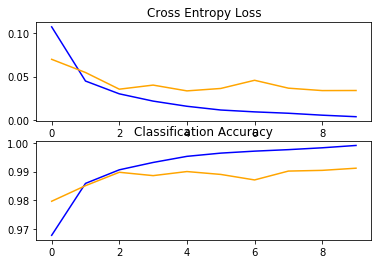

AccuracY: mean=99.117 std=0.000, n=1


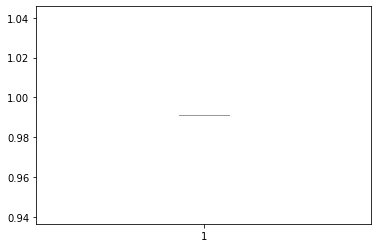

In [108]:
scores3, histories3 = run_test_harness_simplified(learning=0.01)

In [25]:
#same as above, but epochs and batch size are also parameters and returns acc and history just for this run
def evaluate_model_simple(model, dataX, dataY, eps, bs):
    #split into train and test
    trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
    #fit model
    history=model.fit(trainX, trainY, epochs=eps, batch_size=bs, validation_data=(testX, testY), verbose=0)
    #evaluate model
    _, acc=model.evaluate(testX, testY, verbose=0)
    print('>%.3f' % (acc*100.0))
    return acc, history

#present results

#fxn to plot diagnostic learning curves: line plot showing model performance on train and test set during each k-fold validation to get a sense for over vs underfitting
def summarize_diagnostics(history, learning, eps, bs):
    #plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss, lrate={}, epochs={}, batch_size={}'.format(learning, eps, bs))
    pyplot.title('lrate='+str(learning), pad=-50)
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    #plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy, lrate={}, epochs={}, batch_size={}'.format(learning, eps, bs))
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    
#function to summarize the classification accuracy scores collected during each fold
def summarize_performance(acc):
    #print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(acc)*100, std(acc)*100, len(acc)))

#test harness
def run_test_harness_simplified(learning, eps, bs):
    #load and one hot encode dataset
    trainX, trainY, testX, testY = load_dataset()
    #prepare pixel data
    trainX, testX=prep_pixels(trainX, testX)
    #define model
    model=define_model_adapted_deeper(learning)
    #evaluate performance across range of learning rates
    acc, history = evaluate_model_simple(model, trainX, trainY, eps, bs)
    # learning curves
    summarize_diagnostics(history, learning, eps, bs)
    #summarize estimated performance
    summarize_performance(acc)
    return acc, history

>9.792


NameError: name 'lrate' is not defined

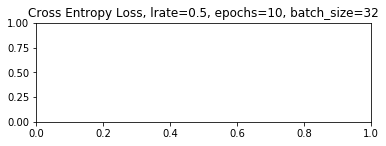

In [117]:
scores4, histories4 = run_test_harness_simplified(learning=0.5, eps=10, bs=32)

In [2]:
# Now going to back adjustments to test range of learning rates and plot loss all together
#same as above, but epochs and batch size are also parameters and returns acc and history just for this run
def evaluate_model_simple(model, dataX, dataY, eps, bs, learning):
    #split into train and test
    trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
    #fit model
    history=model.fit(trainX, trainY, epochs=eps, batch_size=bs, validation_data=(testX, testY), verbose=0)
    #evaluate model
    _, acc=model.evaluate(testX, testY, verbose=0)
    print('>Accuracy: %.3f' % (acc*100.0))
    #plot loss over learning rate
    pyplot.title('Cross Entropy Loss, lrate={}'.format(learning))
    pyplot.title('lrate='+str(learning), pad=-50)
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    return acc, history

#test harness
def run_test_harness_simplified_over_lr(eps, bs):
    #load and one hot encode dataset
    trainX, trainY, testX, testY = load_dataset()
    #prepare pixel data
    trainX, testX=prep_pixels(trainX, testX)
    #define and evaluate model across range of learning rates
    learning_rates=[1, 0.5, 0.3, 0.1, 0.01, 0.001]
    accuracies=[]
    histories=[]
    for i in range(len(learning_rates)):
        #determine plot no
        plot_no = 420 + (i+1)
        pyplot.subplot(plot_no)
        model=define_model_adapted_deeper(learning_rates[i])
        acc, history = evaluate_model_simple(model, trainX, trainY, eps, bs, learning_rates[i])
        accuracies.append(acc)
        histories.append(history)
    return accuracies, histories
    #show learning curves
    pyplot.show()

>Accuracy: 9.792
>Accuracy: 9.792
>Accuracy: 98.767
>Accuracy: 98.025
>Accuracy: 99.058
>Accuracy: 98.567


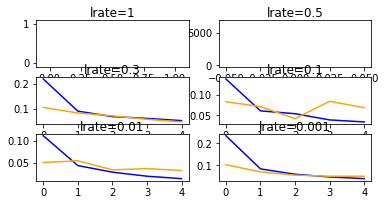

In [31]:
accuracy_scores, histories = run_test_harness_simplified_over_lr(eps=5, bs=32)

#### Will save the final model with a lr=0.01 since that looks the best, fit on the training set only

In [14]:
#will now save a final model with lr = 0.01

#load dataset
def load_dataset():
    #load daaset
    (trainX, trainY), (testX,testY)=mnist.load_data()
    #reshape dataset to have single channel
    trainX=trainX.reshape((trainX.shape[0],28,28,1))
    testX=testX.reshape((testX.shape[0],28,28,1))
    #one hot encode target values
    trainY=to_categorical(trainY)
    testY=to_categorical(testY)
    return trainX, trainY, testX, testY

#prepare pixels
def prep_pixels(train, test):
    #convert from int to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize to range 0-1
    train_norm=train_norm/255.0
    test_norm=test_norm/255.0
    #return nromalized images
    return train_norm, test_norm

#define final model wit lr = 0.01
def define_model_final():
    model=Sequential()
    #add a single convolutional layer with a small filer size (3,3) and modest number of filters (32)
    #NB: all layers will use ReLU activation function and He weight initialization scheme (best practices)
    model.add(Conv2D(32, (3,3), activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
    #add Batch normalization after convolutional layer
    model.add(BatchNormalization())
    #add a max pooling layer
    model.add(MaxPooling2D((2,2)))
    #made model deeped than prior models by adding a double convolutional layer (64 filters each but same sized filters as above), followed by a max pooling layer
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    #Feature extractor: flatten filter maps to provide features to classifier
    model.add(Flatten())
    #dense layer to interpret features (will use 100 nodes here)
    model.add(Dense(100, activation='relu',kernel_initializer='he_uniform'))
    #add batch normalization after fully connected layer
    model.add(BatchNormalization())
    #output layer: task will be to classify each of the 10 digits, so output layer will need 10 nodes to predict prob distribution of the 10 classes
    model.add(Dense(10, activation='softmax'))
    #stochastic gradient descent optimizer: here, learning rate=0.01, and momentum=0.9
    opt=SGD(lr=0.01, momentum=0.9)
    #compile model: categorical x-entropy loss function will be optimized and will monitor classification accuracy metric
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#run test harness for evaluating final model, save model to an H5 file
def run_test_harness_final():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model_final()
    # fit model on training dataset
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    # save model
    model.save('final_model.h5')

#entry point, run the test harness. This will save the model with the name 'final_model.h5' in the working directory
run_test_harness_final()

#### Load the final model, and evaluate it on the hold out test dataset

In [6]:
#load dataset
def load_dataset():
    #load daaset
    (trainX, trainY), (testX,testY)=mnist.load_data()
    #reshape dataset to have single channel
    trainX=trainX.reshape((trainX.shape[0],28,28,1))
    testX=testX.reshape((testX.shape[0],28,28,1))
    #one hot encode target values
    trainY=to_categorical(trainY)
    testY=to_categorical(testY)
    return trainX, trainY, testX, testY

#prepare pixels
def prep_pixels(train, test):
    #convert from int to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize to range 0-1
    train_norm=train_norm/255.0
    test_norm=test_norm/255.0
    #return nromalized images
    return train_norm, test_norm

def run_test_harness_final():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # load model
    model = load_model('final_model.h5')
    #evaluate model on test dataset
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('>%.3f' % (acc*100.0))

#entry point, run the test harness. This will save the model with the name 'final_model.h5' in the working directory
run_test_harness_final()

>98.960


#### Use the saved model to make a prediction

In [17]:
#load and prepare the image that the prediction will be made on
def load_image(filename):
    #load the image, force it ot be grayscale and force size to be 28x28
    img=load_img(filename, grayscale=True, target_size=(28,28))
    #convert to array
    img=img_to_array(img)
    #reshape into a single sample with 1 channel
    img=img.reshape(1,28,28,1)
    #prepare pixel data un the same way prepared for training dataset when fitting the final model (normalize here)
    img=img.astype('float32')
    img=img/255.0
    return img

#load an image and predict the class
def run_example():
    #load the image 
    img=load_image('sample_image.png')
    #load model
    model=load_model('final_model.h5')
    #predict the class
    digit=model.predict_classes(img)
    print(digit[0])
    
#entry point, run the sample
img=run_example()

c:\users\dbitterman\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


7
